# Neuron
Łukasz Klimkiewicz, 244822

In [11]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Numer indeksu
index = 244822

# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Implementacja

### Funkcje aktywacji

In [83]:
class Activation:
    
    def __init__(self, positive, negative, treshold):
        self.positive_class = positive
        self.negative_class = negative
        self.treshold = treshold
    
    def call(self, x):
        raise NotImplementedError('call function is not implemented')
    
    def deriv(self, x):
        raise NotImplementedError('deriv function is not implemented')

In [84]:
class LogisticActivation(Activation):
    
    def __init__(self):
        super().__init__(positive=1, negative=0, treshold=0.5)
    
    def call(self, x):
        return 1 / (1 + np.exp(-x))
    
    def deriv(self, x):
        y = self.call(x)
        return y * (1-y)

In [86]:
class ReLuActivation(Activation):
    
    def __init__(self):
        super().__init__(positive=1, negative=0, treshold=0.5)
    
    def call(self, x):
        return np.maximum(x, 0)
    
    def deriv(self, x):
        return (x > 0).astype(np.float32)

In [88]:
class LeakyReLuActivation(Activation):
    
    def __init__(self, coef=0.01):
        super().__init__(positive=1, negative=0, treshold=0.5)
        self.coef = coef
    
    def call(self, x):
        return np.where(x > 0, x, self.coef*x)
    
    def deriv(self, x):
        return np.where(x > 0, 1, self.coef)
    
    def treshold(self, x):
        return x > 0.5

In [89]:
class TanhActivation(Activation):
    
    def __init__(self):
        super().__init__(positive=1, negative=-1, treshold=0)
    
    def call(self, x):
        return np.tanh(x)
    
    def deriv(self, x):
        return 1 - np.tanh(x) ** 2
    
    def treshold(self, x):
        return x > 0

In [90]:
class SinActivation(Activation):
    
    def __init__(self):
        super().__init__(positive=1, negative=-1, treshold=0)
    
    def call(self, x):
        return np.sin(x)
    
    def deriv(self, x):
        return np.cos(x)
    
    def treshold(self, x):
        return x > 0

In [91]:
class SignActivation(Activation):
    
    def __init__(self):
        super().__init__(positive=1, negative=-1, treshold=0)
    
    def call(self, x):
        return np.sign(x)
    
    def deriv(self, x):
        return np.ones_like(x)
    
    def treshold(self, x):
        return x > 0

In [93]:
class HeavisideActivation(Activation):
    
    def __init__(self):
        super().__init__(positive=1, negative=0, treshold=0.5)
    
    def call(self, x):
        return (x >= 0).astype(np.float32)
    
    def deriv(self, x):
        return np.ones_like(x)
    
    def treshold(self, x):
        return x > 0.5

### Strategie zmiany współczynnika uczenia

In [21]:
class LearningRate:
    
    def __call__(self, n, n_max, epoch):
        raise NotImplementedError('call function is not implemented')

In [22]:
class ConstantLearningRate(LearningRate):
    
    def __init__(self, lr):
        self.lr = lr
    
    def __call__(self, n, epoch, n_max, epoch_max):
        return self.lr

In [23]:
class CosEpochLearningRate(LearningRate):
    
    def __init__(self, lr_min, lr_max):
        self.lr_min = lr_min
        self.lr_max = lr_max
    
    def __call__(self, n, epoch, n_max, epoch_max):
        const_part = self.lr_min + (self.lr_max - self.lr_min)
        var_part = 1 + np.cos(epoch / epoch_max * np.pi)
        return const_part + var_part

### Neuron

In [100]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin

class Neuron(BaseEstimator, ClassifierMixin):

    def __init__(self, activation: Activation, learning_rate: LearningRate, batch_size=1, tol=None, max_iter=100):
        self.activation = activation
        self.batch_size = batch_size
        self.tol = tol
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        
        self.w_ = None
        self.lr_values = None

    def fit(self, X, y):
        y = np.where(y == 1, self.activation.positive_class, self.activation.negative_class)
        y = y.reshape(-1, 1)
        X = np.hstack([-1*np.ones((X.shape[0], 1)), X])
        self.w_ = np.random.randn(X.shape[1], 1)

        for i in range(self.max_iter):
            X_shuffled, y_shuffled = self._shuffle(X, y)
            lr = self._generate_lr(i, X.shape[0])
            weights_delta = self._learn_epoch(X_shuffled, y_shuffled, lr)
            if self.tol != None and np.all(np.abs(weights_delta) < self.tol):
                break

        return self
    
    def _shuffle(self, X, y):
        merged = np.hstack([X, y])
        np.random.shuffle(merged)
        new_X, new_y = np.split(merged, [-1], axis=1)
        return new_X, new_y
    
    def _generate_lr(self, epoch, n_max):
        lr = [self.learning_rate(n, epoch, n_max, self.max_iter) for n in range(n_max)]
        return np.array(lr).reshape(-1, 1)

    def _learn_epoch(self, X, Y, lr):
        weights_before = self.w_.copy()
        
        samples_count = X.shape[0]
        batches_count = math.ceil(samples_count / self.batch_size)
        
        X_batches = np.array_split(X, batches_count);
        Y_batches = np.array_split(Y, batches_count);
        lr_batches = np.array_split(lr, batches_count);
        
        for X_batch, Y_batch, lr_batch in zip(X_batches, Y_batches, lr_batches):
            self._learn_batch(X_batch, Y_batch, lr_batch)
        
        weights_delta = self.w_ - weights_before
        return weights_delta
        
    def _learn_batch(self, X, Y, lr):
        multiplied = X@self.w_
        activated = self.activation.call(multiplied)
        diff = Y - activated
        deriv = self.activation.deriv(multiplied)
        deltas = lr * diff * deriv * X
        delta = np.mean(deltas, axis=0)
        self.w_ += delta.reshape(-1, 1)

    def decision_function(self, X):
        X = np.hstack([-1*np.ones((X.shape[0], 1)), X])
        multiplied = X@self.w_
        activated = self.activation.call(multiplied)
        return activated.ravel()

    def predict(self, X):
        return (self.decision_function(X) > self.activation.treshold).astype(np.int_)

## Generowanie danych

In [25]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn1_x, syn1_y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=1, random_state=seed, class_sep=1)

# Podział na zbiory
syn1_train_x, syn1_test_x, syn1_train_y, syn1_test_y = train_test_split(
    syn1_x, syn1_y, test_size=.2, random_state=seed, stratify=syn1_y)

# Strukturyzacja
syn1_data = {
    'train': {
        'x': syn1_train_x,
        'y': syn1_train_y
    },
    'test': {
        'x': syn1_test_x,
        'y': syn1_test_y
    }
}

In [26]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generowanie
syn2_x, syn2_y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

# Podział na zbiory
syn2_train_x, syn2_test_x, syn2_train_y, syn2_test_y = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn2_data = {
    'train': {
        'x': syn2_train_x,
        'y': syn2_train_y,
    },
    'test': {
        'x': syn2_test_x,
        'y': syn2_test_y,
    }
}

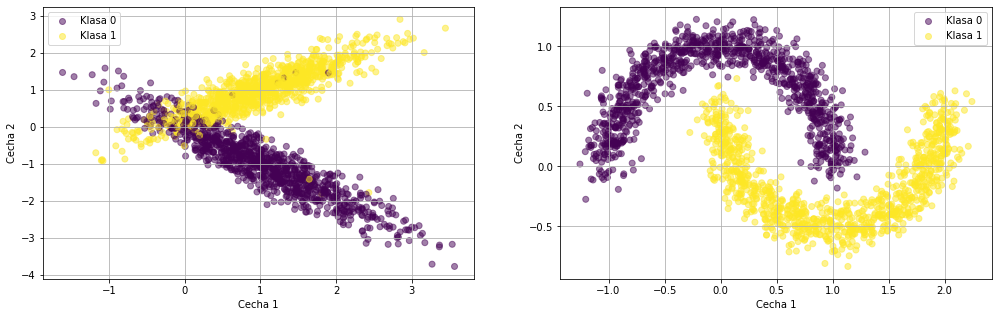

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))

for ax, data in zip(axs, [syn1_data, syn2_data]):
    scatter = ax.scatter(data['train']['x'][:,0], data['train']['x'][:,1], c=data['train']['y'], alpha=0.5)
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

## Testy różnych funkcji aktywacji

### Funkcje pomocnicze

In [28]:
def plot_classifier(classifier, X, y, *, ax, margin=0.2, resolution=100, 
                    title='Powierzchnia decyzyjna', xl='Cecha 1', yl='Cecha 2'):
    
    data = {'x': X, 'y': y}

    x1 = data['x'][:,0].min() - margin
    x2 = data['x'][:,0].max() + margin
    y1 = data['x'][:,1].min() - margin
    y2 = data['x'][:,1].max() + margin

    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = classifier.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title);
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

In [29]:
def train_neuron(activation, data):
    neuron = Neuron(
        activation, 
        ConstantLearningRate(1e-2), 
        batch_size=1, 
        max_iter=200, 
        tol=None
    )
    neuron.fit(data['train']['x'], data['train']['y'])
    return neuron

In [30]:
def plot_neurons(neurons, data):
    count = len(neurons)
    rows = math.ceil(count / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(18, rows*6))
    if count % 2 != 0:
        fig.delaxes(axs[-1][-1])
    
    for i, activation_name in enumerate(neurons):
        row = i // 2
        col = i % 2
        ax = axs[row][col]
        
        neuron = neurons[activation_name]
        plot_classifier(neuron, data['test']['x'], data['test']['y'], ax=ax, resolution=200, title=activation_name)

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrixes(neurons, data):
    count = len(neurons)
    rows = math.ceil(count / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(7, rows*3))
    if count % 2 != 0:
        fig.delaxes(axs[-1][-1])
    
    for i, activation_name in enumerate(neurons):
        row = i // 2
        col = i % 2
        ax = axs[row][col]
        
        neuron = neurons[activation_name]
        predictions = neuron.predict(data['test']['x'])
        ConfusionMatrixDisplay.from_predictions(data['test']['y'], predictions, ax=ax)
        ax.set_title(activation_name)
    
    fig.tight_layout()

In [32]:
from sklearn.metrics import recall_score, f1_score, accuracy_score

def show_neurons_metrics(neurons, data):
    records = []

    for activation_name, neuron in neurons.items():

        predictions = neuron.predict(data['train']['x'])

        sens = recall_score(data['train']['y'], predictions)
        spec = recall_score(data['train']['y'], predictions, pos_label=0)
        f1 = f1_score(data['train']['y'], predictions)
        acc = accuracy_score(data['train']['y'], predictions)

        record = (activation_name, sens, spec, acc, f1)
        records.append(record)
            
    matrix = np.array(records)

    df = pd.DataFrame({
        'Activation': matrix[:, 0],
        'Sensitivity': matrix[:, 1],
        'Specificity': matrix[:, 2],
        'Accuracy': matrix[:, 3],
        'F1': matrix[:, 4], 
    })
    
    df = df.set_index(['Activation']).sort_values('F1', ascending=False)
    return df

In [33]:
from sklearn.metrics import RocCurveDisplay

def show_roc_curves(neurons, data):
    count = len(neurons)
    rows = math.ceil(count / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(13, rows*4))
    if count % 2 != 0:
        fig.delaxes(axs[-1][-1])
    
    for i, activation_name in enumerate(neurons):
        row = i // 2
        col = i % 2
        ax = axs[row][col]
        
        neuron = neurons[activation_name]
        predictions = neuron.decision_function(data['train']['x'])
        
        RocCurveDisplay.from_predictions(data['train']['y'], predictions, ax=ax)
        ax.grid()
        ax.set_title(activation_name)
        
    fig.tight_layout()

In [34]:
from sklearn.base import clone
import timeit

def measure_times(neurons, data, n_fit=1, n_predict=1):
    records = []
    
    for activation_name in neurons:
        neuron = neurons[activation_name]
        cloned_model = clone(neuron)

        def time_fit():
            cloned_model.fit(data['train']['x'], data['train']['y'])

        def time_predict():
            cloned_model.predict(data['test']['x'])

        fit_time = timeit.timeit(time_fit, number=n_fit) / n_fit
        predict_time = timeit.timeit(time_predict, number=n_predict) / n_predict

        record = (activation_name, fit_time, predict_time)
        records.append(record)
        
    matrix = np.array(records)

    df = pd.DataFrame({
        'Activation': matrix[:,0],
        'Fit time': matrix[:,1],
        'Predict time': matrix[:,2],
    })
    
    df = df.set_index(['Activation']).sort_index()
    return df

### Zbiór danych 1

In [101]:
neurons_1 = {
    'Logistic': train_neuron(LogisticActivation(), syn1_data),
    'Relu': train_neuron(ReLuActivation(), syn1_data),
    'Leaky Relu': train_neuron(LeakyReLuActivation(0.01), syn1_data),
    'Tanh': train_neuron(TanhActivation(), syn1_data),
    'Sin': train_neuron(SinActivation(), syn1_data),
    'Heaviside': train_neuron(HeavisideActivation(), syn1_data),
    'Sign': train_neuron(SignActivation(), syn1_data),
}

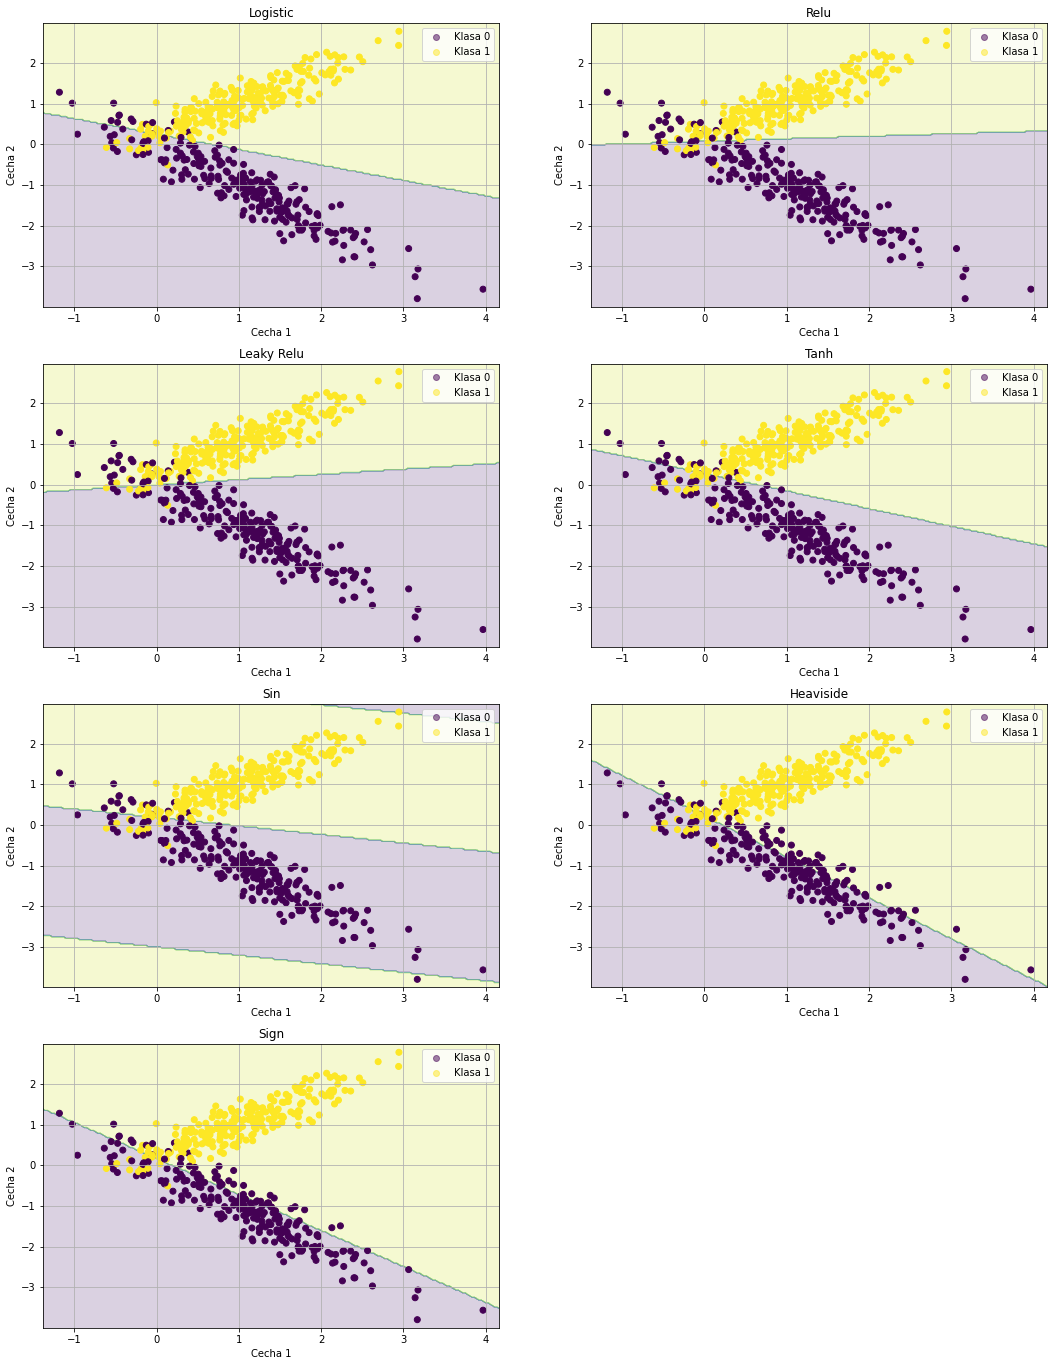

In [102]:
plot_neurons(neurons_1, syn1_data)

In [103]:
show_neurons_metrics(neurons_1, syn1_data)

,Sensitivity,Specificity,Accuracy,F1
Activation,,,,
Leaky Relu,0.9484004127966976,0.8739669421487604,0.9112028910686629,0.9144278606965174
Relu,0.9318885448916409,0.8884297520661157,0.9101703665462054,0.9121212121212121
Tanh,0.891640866873065,0.9328512396694215,0.9122354155911203,0.9104320337197048
Logistic,0.8937048503611971,0.9297520661157025,0.9117191533298916,0.9101418812401472
Sin,0.9050567595459237,0.9152892561983471,0.9101703665462054,0.9097510373443983
Sign,0.9153766769865841,0.7851239669421488,0.8502839442436758,0.8594961240310077
Heaviside,0.9112487100103199,0.7262396694214877,0.8187919463087249,0.834199338686821


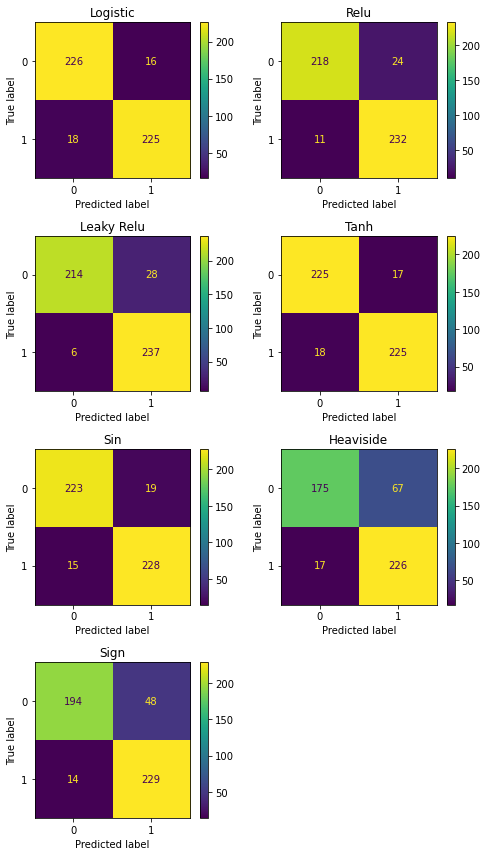

In [104]:
plot_confusion_matrixes(neurons_1, syn1_data)

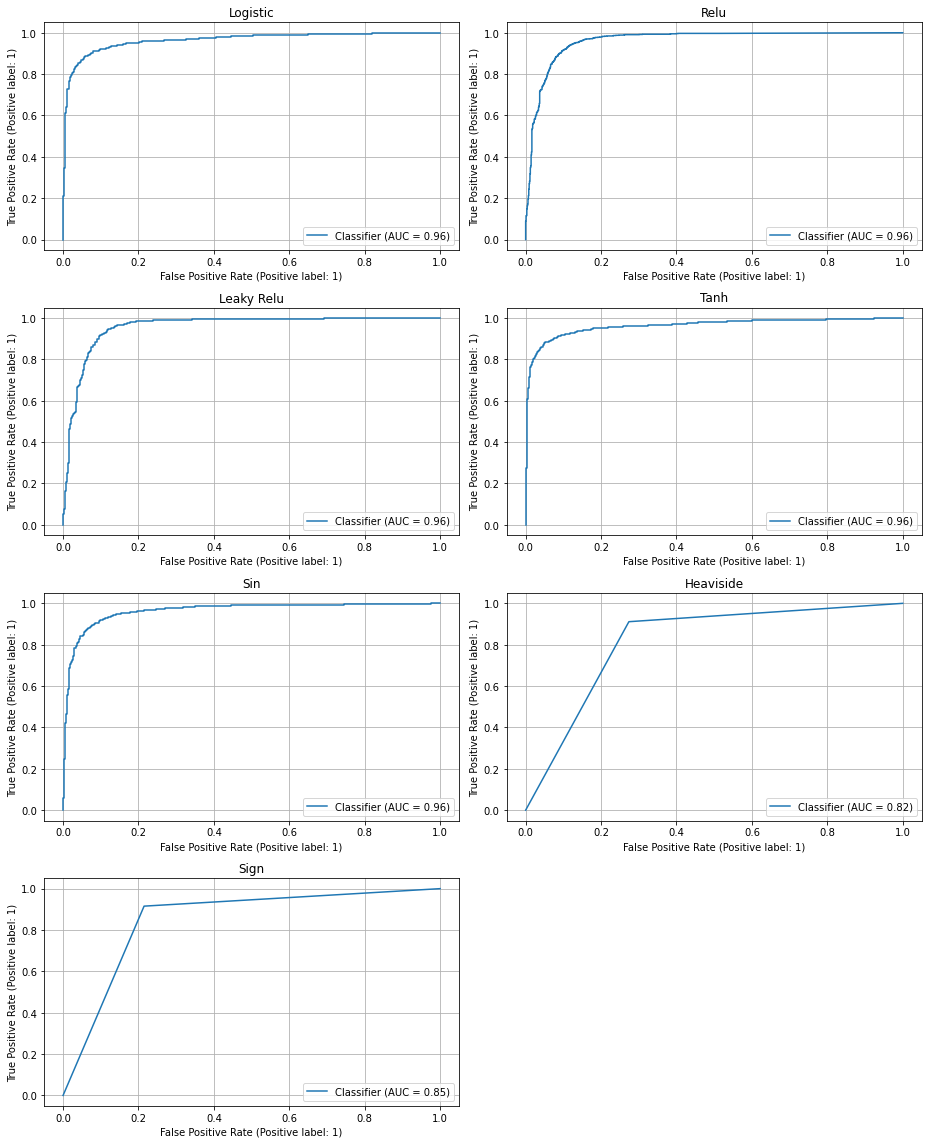

In [105]:
show_roc_curves(neurons_1, syn1_data)

In [43]:
measure_times(neurons_1, syn1_data, n_predict=100)

,Fit time,Predict time
Activation,,
Heaviside,10.89086930000002,1.886700000000019e-05
Leaky Relu,11.428750100000002,2.1248999999556872e-05
Logistic,11.14910199999997,2.310200000010809e-05
Relu,9.8413137,1.8660000000068065e-05
Sign,9.504931400000032,1.773399999990488e-05
Sin,8.340826800000002,2.1164999999996325e-05
Tanh,9.15545609999998,2.166500000043925e-05


### Zbiór danych 2

In [106]:
neurons_2 = {
    'Logistic': train_neuron(LogisticActivation(), syn2_data),
    'Relu': train_neuron(ReLuActivation(), syn2_data),
    'Leaky Relu': train_neuron(LeakyReLuActivation(0.01), syn2_data),
    'Tanh': train_neuron(TanhActivation(), syn2_data),
    'Sin': train_neuron(SinActivation(), syn2_data),
    'Heaviside': train_neuron(HeavisideActivation(), syn2_data),
    'Sign': train_neuron(SignActivation(), syn2_data),
}

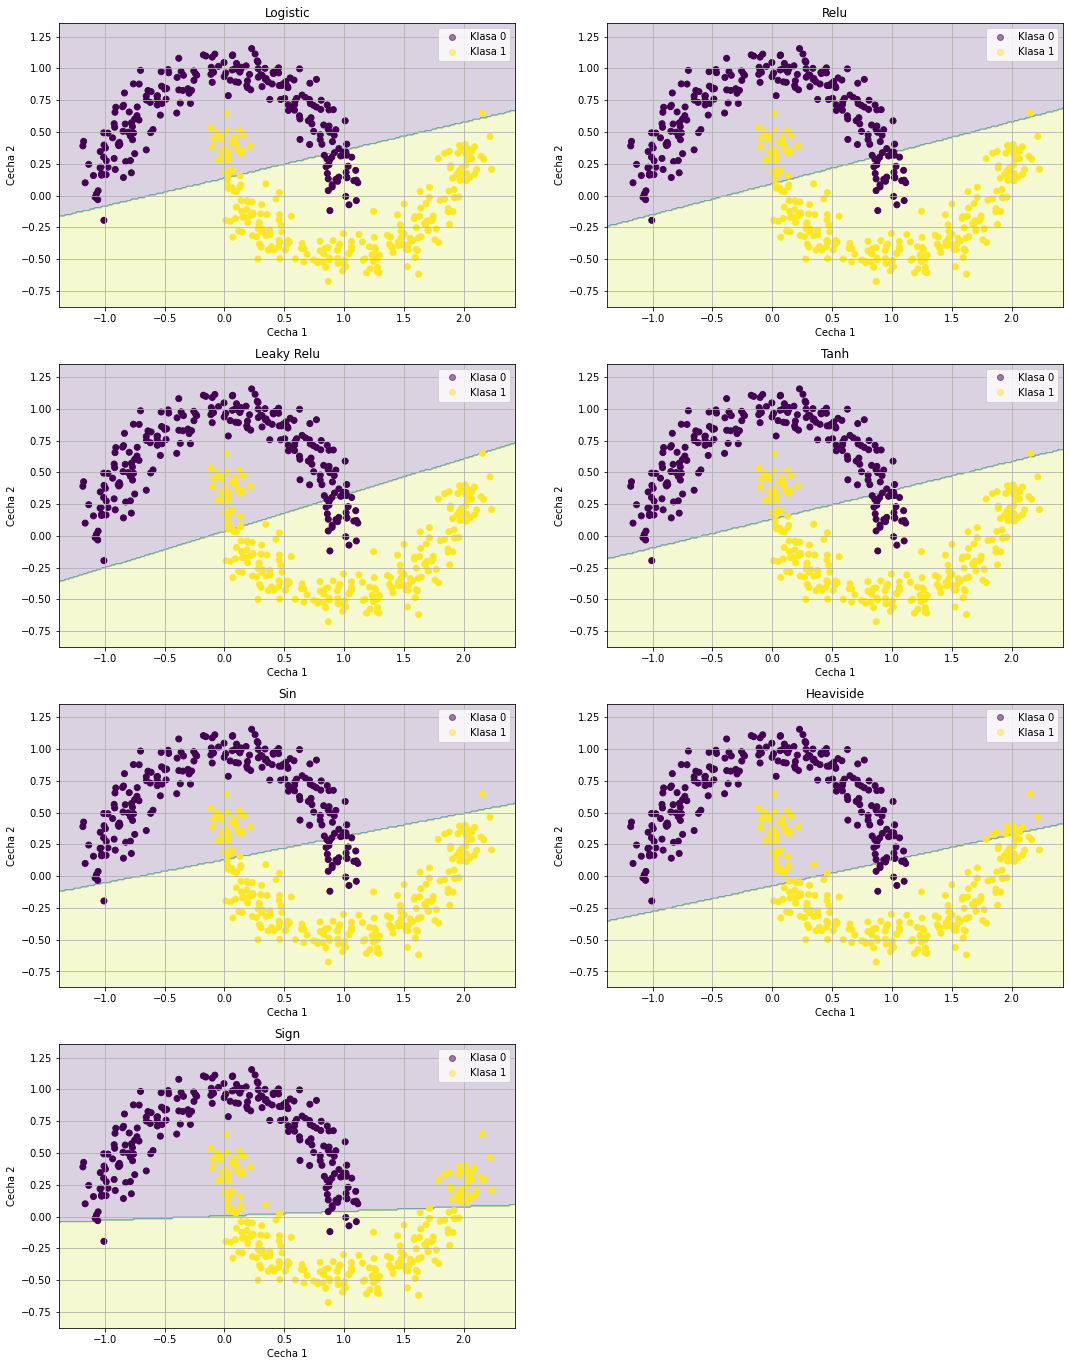

In [107]:
plot_neurons(neurons_2, syn2_data)

In [108]:
show_neurons_metrics(neurons_2, syn2_data)

,Sensitivity,Specificity,Accuracy,F1
Activation,,,,
Tanh,0.8846153846153846,0.8892307692307693,0.8869385647909138,0.8859968766267569
Logistic,0.8856548856548857,0.8871794871794871,0.8864223025296851,0.8856548856548857
Relu,0.8690228690228691,0.8933333333333333,0.8812596799173981,0.879074658254469
Sin,0.8669438669438669,0.8882051282051282,0.8776458440887971,0.8755905511811024
Leaky Relu,0.8565488565488566,0.9005128205128206,0.8786783686112545,0.8751991502920871
Heaviside,0.7723492723492723,0.9528205128205128,0.8631905007743934,0.8486579097658481
Sign,0.7016632016632016,0.961025641025641,0.8322147651006712,0.8059701492537313


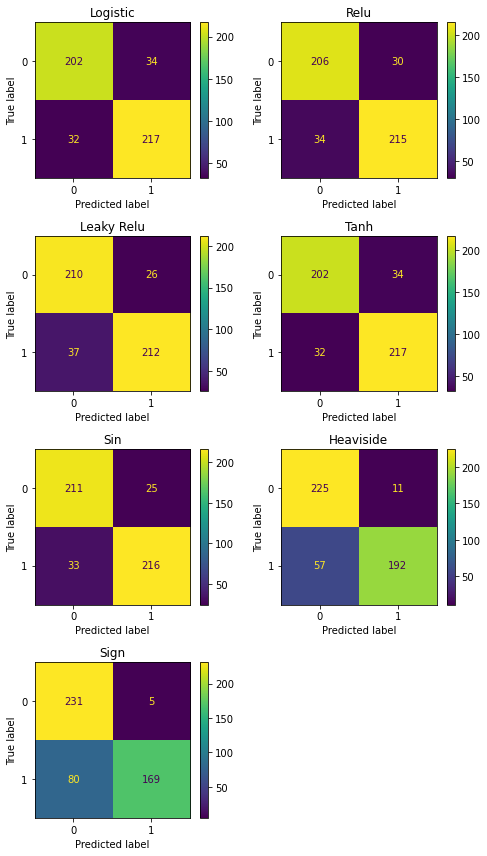

In [109]:
plot_confusion_matrixes(neurons_2, syn2_data)

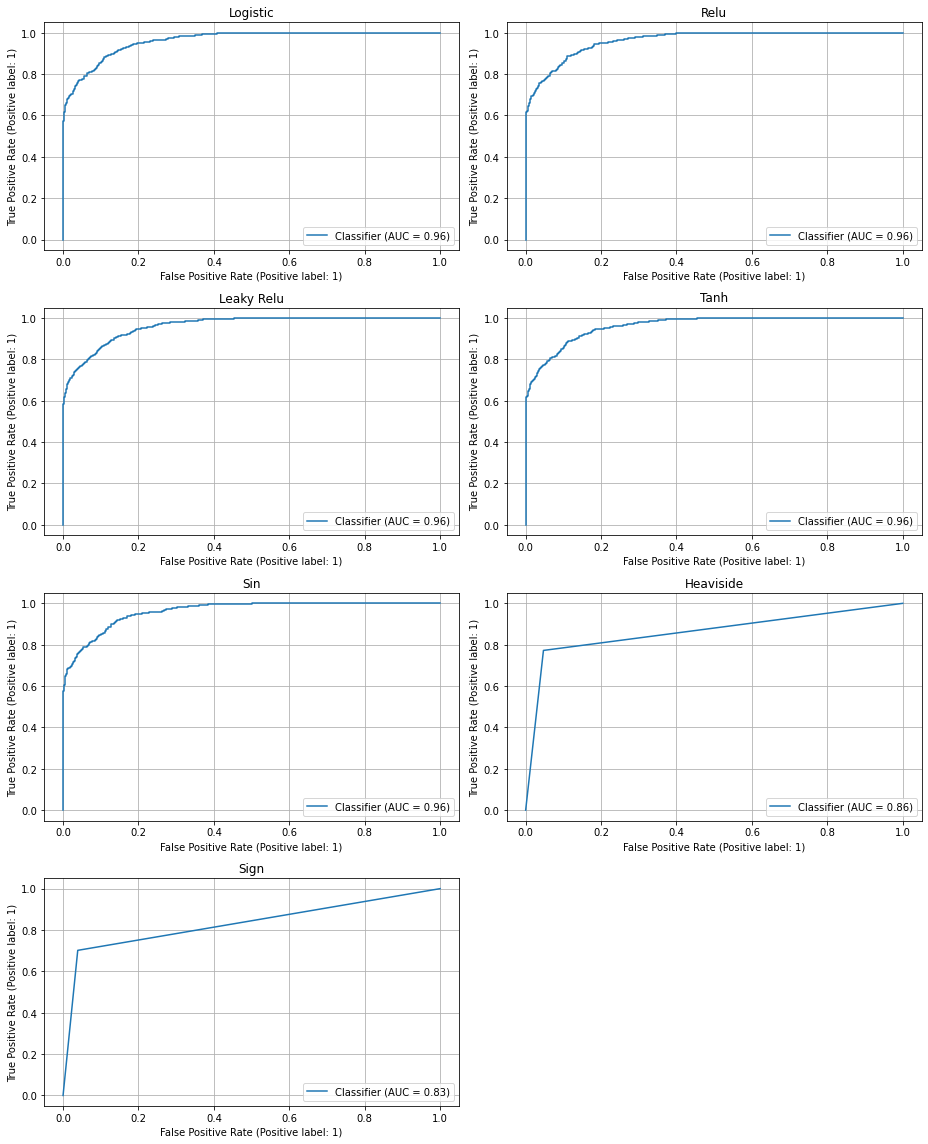

In [110]:
show_roc_curves(neurons_2, syn2_data)

In [638]:
measure_times(neurons_2, syn2_data, n_predict=100)

,Fit time,Predict time
Activation,,
Heaviside,11.611519199970644,1.7871999880298972e-05
Leaky Relu,12.300009500002488,1.9943999941460788e-05
Logistic,16.279116399993654,2.179900009650737e-05
Relu,10.512643400055822,1.7263000481761993e-05
Sign,10.250052099989261,1.6387999639846385e-05
Sin,8.975583999999799,1.8929000361822546e-05
Tanh,9.855973800003994,2.6851000147871672e-05


### Zbiór danych 2 (cechy wielomianowe)

In [111]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def train_neuron_poly(activation, data):
    poly_features = PolynomialFeatures(degree=3)
    
    neuron = Neuron(
        activation, 
        ConstantLearningRate(1e-2), 
        batch_size=1, 
        max_iter=200, 
        tol=None
    )
    
    model = make_pipeline(poly_features, neuron)
    
    model.fit(data['train']['x'], data['train']['y'])
    return model

In [112]:
neurons_2 = {
    'Logistic': train_neuron_poly(LogisticActivation(), syn2_data),
    'Relu': train_neuron_poly(ReLuActivation(), syn2_data),
    'Leaky Relu': train_neuron_poly(LeakyReLuActivation(0.01), syn2_data),
    'Tanh': train_neuron_poly(TanhActivation(), syn2_data),
    'Sin': train_neuron_poly(SinActivation(), syn2_data),
    'Heaviside': train_neuron_poly(HeavisideActivation(), syn2_data),
    'Sign': train_neuron_poly(SignActivation(), syn2_data),
}

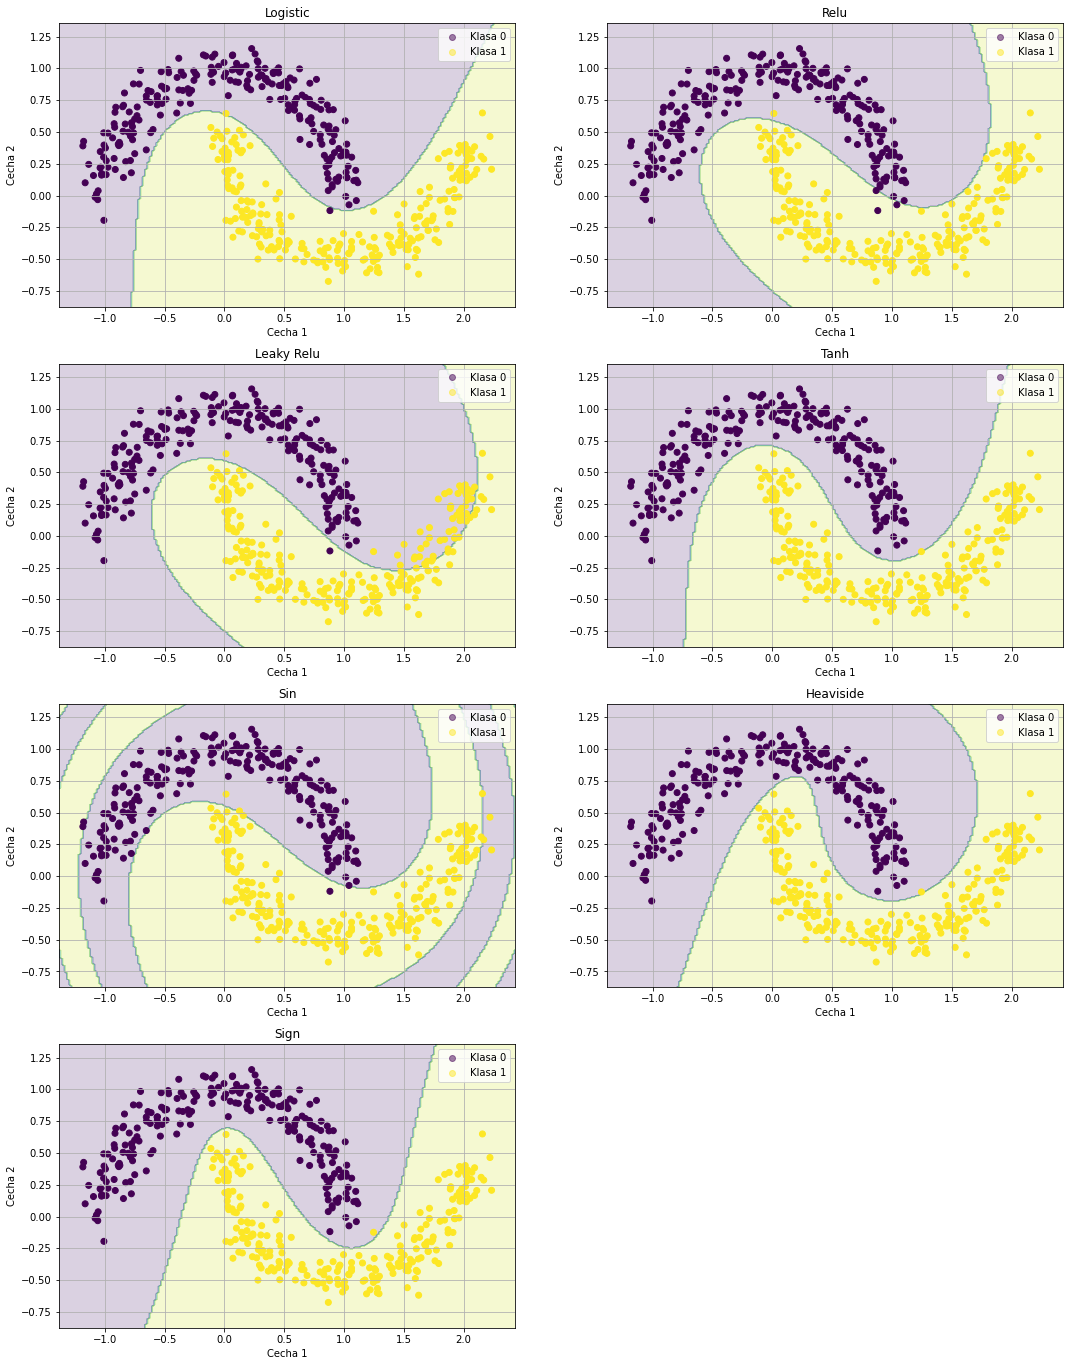

In [113]:
plot_neurons(neurons_2, syn2_data)

In [114]:
show_neurons_metrics(neurons_2, syn2_data)

,Sensitivity,Specificity,Accuracy,F1
Activation,,,,
Heaviside,1.0,1.0,1.0,1.0
Tanh,0.998960498960499,1.0,0.9994837377387713,0.999479979199168
Sign,0.997920997920998,1.0,0.9989674754775426,0.9989594172736733
Logistic,0.9968814968814969,0.9969230769230769,0.9969024264326277,0.9968814968814969
Relu,0.9896049896049897,0.9876923076923076,0.9886422302529685,0.9885773624091382
Sin,0.9802494802494802,0.9866666666666667,0.9834796076406814,0.9833159541188738
Leaky Relu,0.7681912681912682,0.9958974358974358,0.8828084667010841,0.8668621700879765


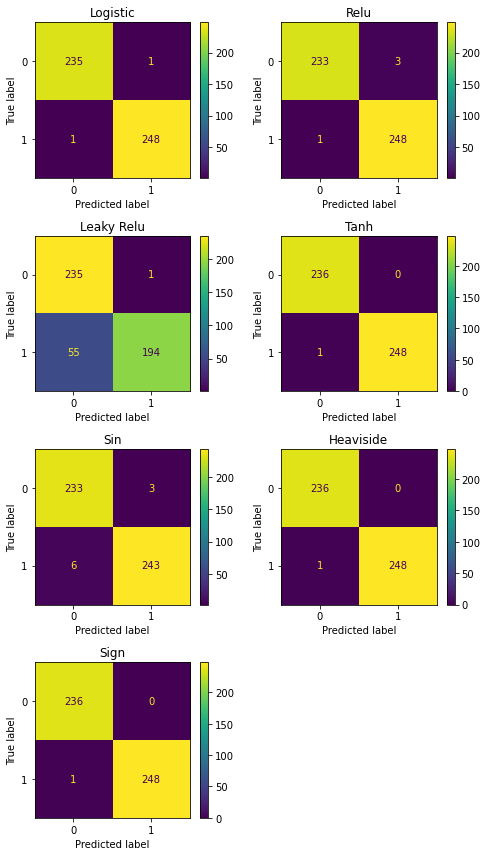

In [115]:
plot_confusion_matrixes(neurons_2, syn2_data)

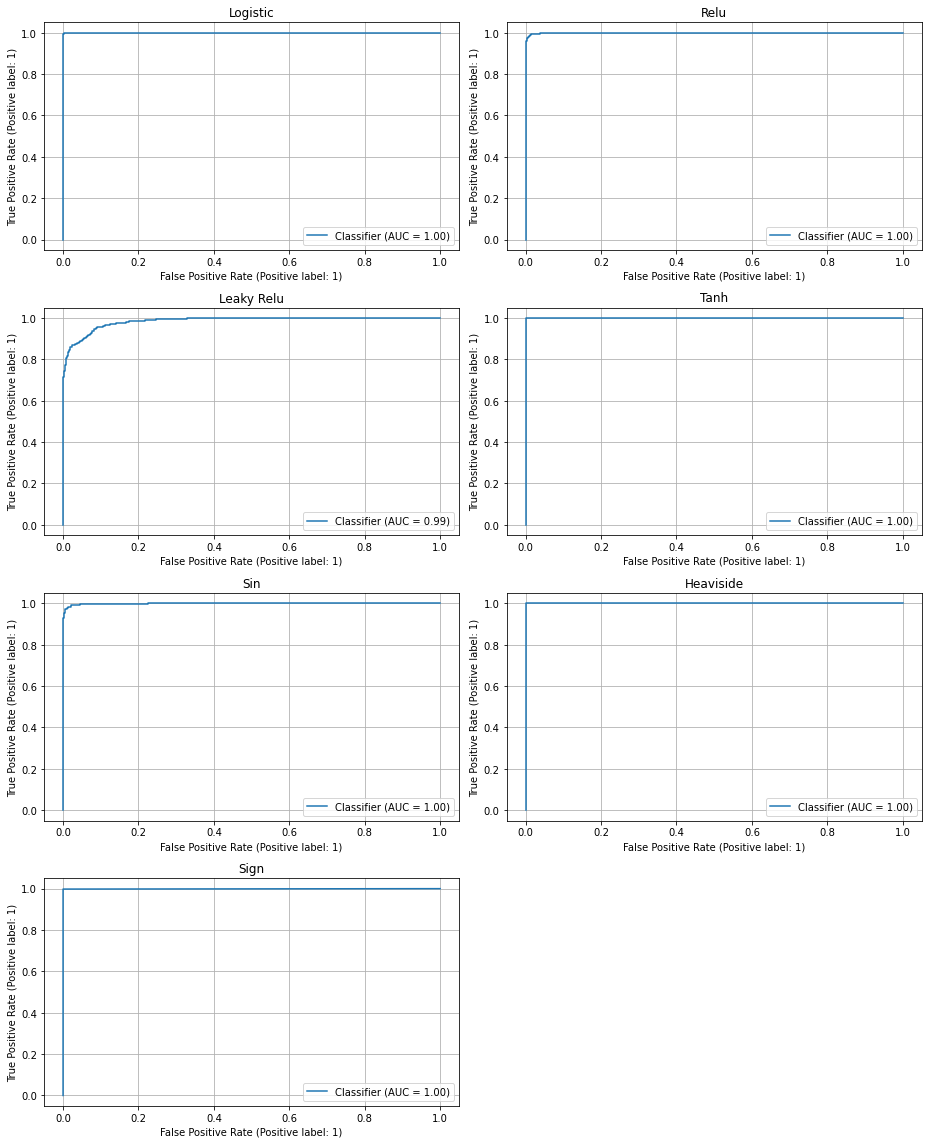

In [116]:
show_roc_curves(neurons_2, syn2_data)

In [555]:
measure_times(neurons_2, syn2_data, n_predict=100)

,Fit time,Predict time
Activation,,
Heaviside,9.95782219999819,0.00012813900000764987
Leaky Relu,11.770772699994268,0.00011621899997408036
Logistic,11.474997500001336,0.0001200539999990724
Relu,10.070439099996292,0.00011909599998034537
Sign,8.717669099998602,0.0001187279999430757
Sin,8.605150699993828,0.00011548500006028917
Tanh,9.434160600001633,0.00012432499999704306


## Uczenie batchami

### Funkcje pomocnicze

In [497]:
from time import time
from sklearn.metrics import f1_score, balanced_accuracy_score

def train_neurons_with_batches(batches, data):
    results = {}
    
    for batch in batches:
        
        fit_time_list = []
        f1_list = []
        acc_list = []
        
        for i in range(5):
            
            neuron = Neuron(
                LogisticActivation(), 
                ConstantLearningRate(1e-2), 
                batch_size=batch, 
                max_iter=200, 
                tol=None
            )

            start = time()
            neuron.fit(data['train']['x'], data['train']['y'])
            fit_time = time() - start

            predictions = neuron.predict(data['test']['x'])
            f1 = f1_score(data['test']['y'], predictions)
            acc = balanced_accuracy_score(data['test']['y'], predictions)
            
            fit_time_list.append(fit_time)
            f1_list.append(f1)
            acc_list.append(acc)
        
        results[batch] = {
            'fit_time': np.mean(fit_time),
            'f1': np.mean(f1),
            'acc': np.mean(acc),
        }

    return results

In [498]:
def plot_attribute(batch_data, attribute, label):
    fig, ax = plt.subplots(figsize=(11, 6))
    batches = list(batch_data.keys())
    values = [subresult[attribute] for subresult in batch_data.values()]
    ax.plot(batches, values, 'o-')
    ax.set_xlabel('Batch size')
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.grid()

### Wyniki

In [504]:
batch_data = train_neurons_with_batches([1, 2, 4, 8, 16, 32, 64, 128, 200, 256], syn1_data)

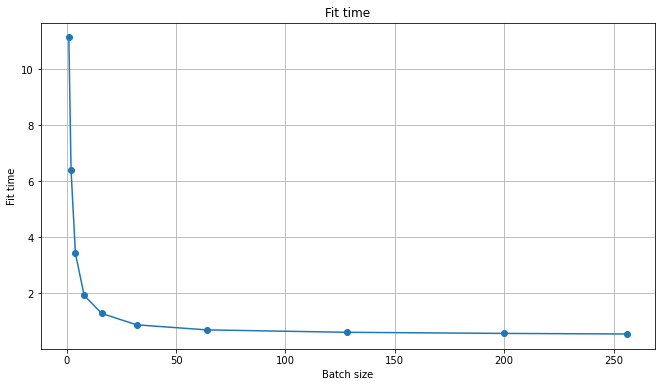

In [505]:
plot_attribute(batch_data, 'fit_time', label='Fit time')

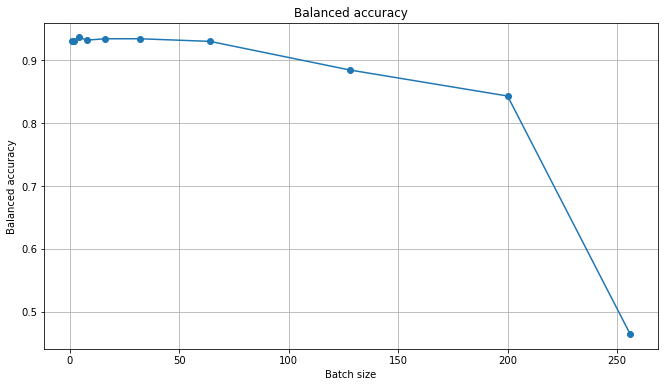

In [506]:
plot_attribute(batch_data, 'acc', label='Balanced accuracy')

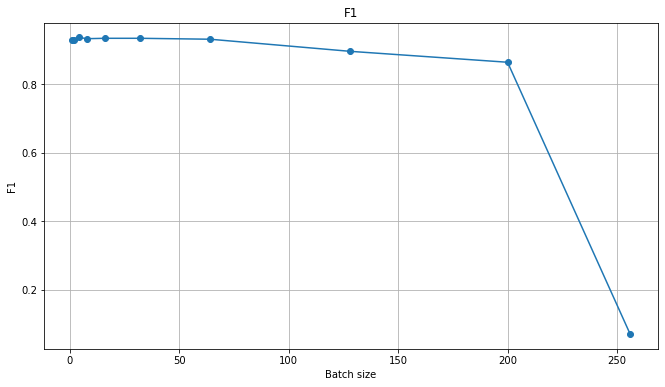

In [507]:
plot_attribute(batch_data, 'f1', label='F1')

### Zmienna szybkość uczenia

In [582]:
def train_neuron_lr(learning_rate):
    neuron = Neuron(
        LogisticActivation(), 
        learning_rate, 
        batch_size=1, 
        max_iter=50, 
        tol=None
    )
    neuron.fit(syn1_data['train']['x'], syn1_data['train']['y'])
    return neuron

In [595]:
neurons_lr = {
    'Small': train_neuron_lr(ConstantLearningRate(1e-4)),
    'Large': train_neuron_lr(ConstantLearningRate(10)),
    'Cos': train_neuron_lr(CosEpochLearningRate(1e-4, 10)),
}

In [596]:
show_neurons_metrics(neurons_lr, syn1_data)

,Sensitivity,Specificity,Accuracy,F1
Activation,,,,
Cos,0.8998968008255934,0.9214876033057852,0.9106866288074342,0.9097548252477831
Large,0.9195046439628483,0.8925619834710744,0.9060402684563759,0.9073319755600815
Small,0.41279669762641896,0.8553719008264463,0.6339700567888488,0.5301524188204109
